# Data Exploration and Analysis of Pakistan Bhasha Dam Fund

This notebook will take you through the data exploration process on the dataset. We will be using graphs to visualize the data, then move on to some mathemetical descriptions of the data, and then come up with some hypotheses to explain our findings.

## Setting up

For this notebook, one should already have **Anaconda** installed as well **Seaborn**. One can check your Seaborn version by typing 
```conda list seaborn```. Currently, Anaconda does not natively allow you to update Seaborn to the latest 0.9.0 version. The [0.9.0 version](https://seaborn.pydata.org/whatsnew.html) of Seaborn has new and extremely useful plotting functions, such as lineplot() and relplot(), that will help you with the exploration. **Only do the following steps if you do not have Seaborn 0.9 and would like to use it. This homework can be done just as well without it. You can also update Seaborn without making a new environment, but then you run the risk of breaking your base environment in which case anaconda would have to be reinstalled.**

To update your Seaborn version, first create a [new Python-3 environment](https://conda.io/docs/user-guide/tasks/manage-environments.html) in your anaconda, to avoid breaking the base environment, by running the following command:

```conda create -n py36 python=3.6 anaconda```

Verify the environment was installed by typing:

```conda env list```

Switch to this environment when you want to work in it by typing:

```source activate py36``` (macOS/Linux) or ```activate py36```(Windows)

Update Seaborn: 

```conda install -c anaconda seaborn=0.9.0 --no-deps```

Switch back to base whenever you are done by: 

```source deactivate```

## Defining the Question

In this notebook, we'll be exploring mainly two questions. At the end we choose a question of our own to explore!
1. How are the donations distributed? This is a overaching question that will mainly be answering many sub-questions
    1. Is there an overall increase or decrease in donations?
    2. Is there a pattern? Is the pattern weekly or monthly?
    3. Are there any spikes? If yes, can you hypothesize why?
2. In how much time will the Dam target of be reached.

## 1. Finding distribution, historical trends and correlations

### Subpart 1-A: Distribution of the data

In [2]:
import numpy as np
import pandas as pd


path = './'
data = pd.read_pickle(path+'individual_contributions.pkl') ## this is a compressed form of data csv files.

data.head()

## D’Agostino’s K^2 Test for Normality
from scipy.stats import normaltest

stat, p = normaltest(data["Amount"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
## Anderson-Darling Test for Data normality  

from scipy.stats import anderson

result = anderson(data["Amount"])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
        


Statistics=895683.201, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 61357.786
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [3]:
# Because Data is not normal for Amounts.
# so using InterQuartile Range method to detect outliers

from numpy import percentile
print(data.head())
# calculate interquartile range
q5, q95 = percentile(data["Amount"], 5), percentile(data["Amount"], 95)
iqr = q95 - q5
print('Percentiles: 5th=%.4f, 95th=%.4f, IQR=%.4f' % (q5, q95, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q5 - cut_off, q95 + cut_off
# identify outliers
outliers = [x for x in data["Amount"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in data["Amount"] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))
clean_data = data[(data["Amount"]>=lower) & (data["Amount"] <= upper)]


                            Bank                Name  Amount       Date
0  AL BARAKA BANK (PAKISTAN) LTD            ADC 0117    25.0 2018-09-10
1  AL BARAKA BANK (PAKISTAN) LTD       SARFARAZ 0117   100.0 2018-09-10
2  AL BARAKA BANK (PAKISTAN) LTD  HAMNA ZEESHAN 0117   100.0 2018-09-10
3  AL BARAKA BANK (PAKISTAN) LTD            ADC 0117   200.0 2018-09-10
4  AL BARAKA BANK (PAKISTAN) LTD          NOMAN 0117   200.0 2018-09-10
Percentiles: 5th=50.0000, 95th=50000.0000, IQR=49950.0000
Identified outliers: 2512
Non-outlier observations: 160817


#### Plotting individual contributions
Below this cell make plots that give us an initial view of how the amounts are distribution i.e. how much money each person usually pays. Go through the [Seaborn Documentation](https://seaborn.pydata.org/tutorial.html) to find out more. Also have a look at the [example gallery](https://seaborn.pydata.org/examples/index.html) to know what each visualization gives us.

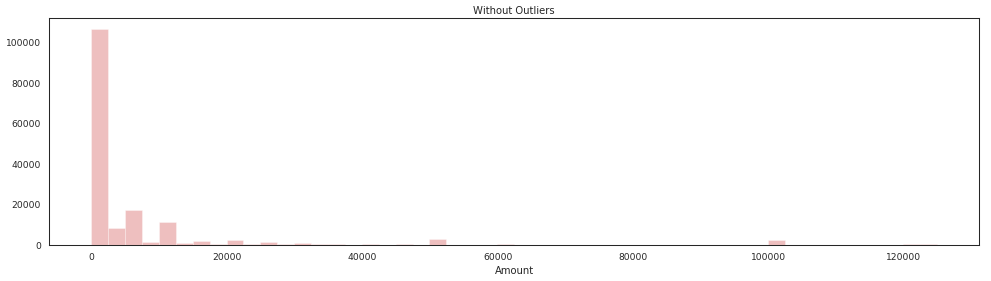

In [5]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(1,figsize=(20,5), dpi=60)
ax.set_title('Without Outliers')

# Plot a historgram and kernel density estimate
sns.distplot(clean_data["Amount"], color="r", kde=False, label="Without Outliers")

#### Explaining outliers

In [6]:
outliers_data = data[(data["Amount"]<lower) | (data["Amount"] > upper)]
outliers_data.head()

,Bank,Name,Amount,Date
57,AL BARAKA BANK (PAKISTAN) LTD,NOOR HUSSAIN 0117,200000.0,2018-09-10
58,AL BARAKA BANK (PAKISTAN) LTD,ADC 0117,250000.0,2018-09-10
1310,Allied Bank Limited,JAVAD SAEED,175000.0,2018-09-10
1311,Allied Bank Limited,KAMRAJ ENT PVT LTD,200000.0,2018-09-10
1312,Allied Bank Limited,JAMILUDDIN HAIDER,600000.0,2018-09-10


There are few donors that donated large amounts and can disrupt our general distribution. Keeping them or discarding them from data, really depends on the context, if it matters to include every one to analyze the data, then keeping is a good option otherwise there are very few and discarding them can save us from many pitfalls.

### Subpart 1-b: Finding Daily Patterns
We are now interesting in finding how the contributions change over time - in terms of the sum of contributions over a day, the number of contributions over a day, and see their pattern over a time-series plot.

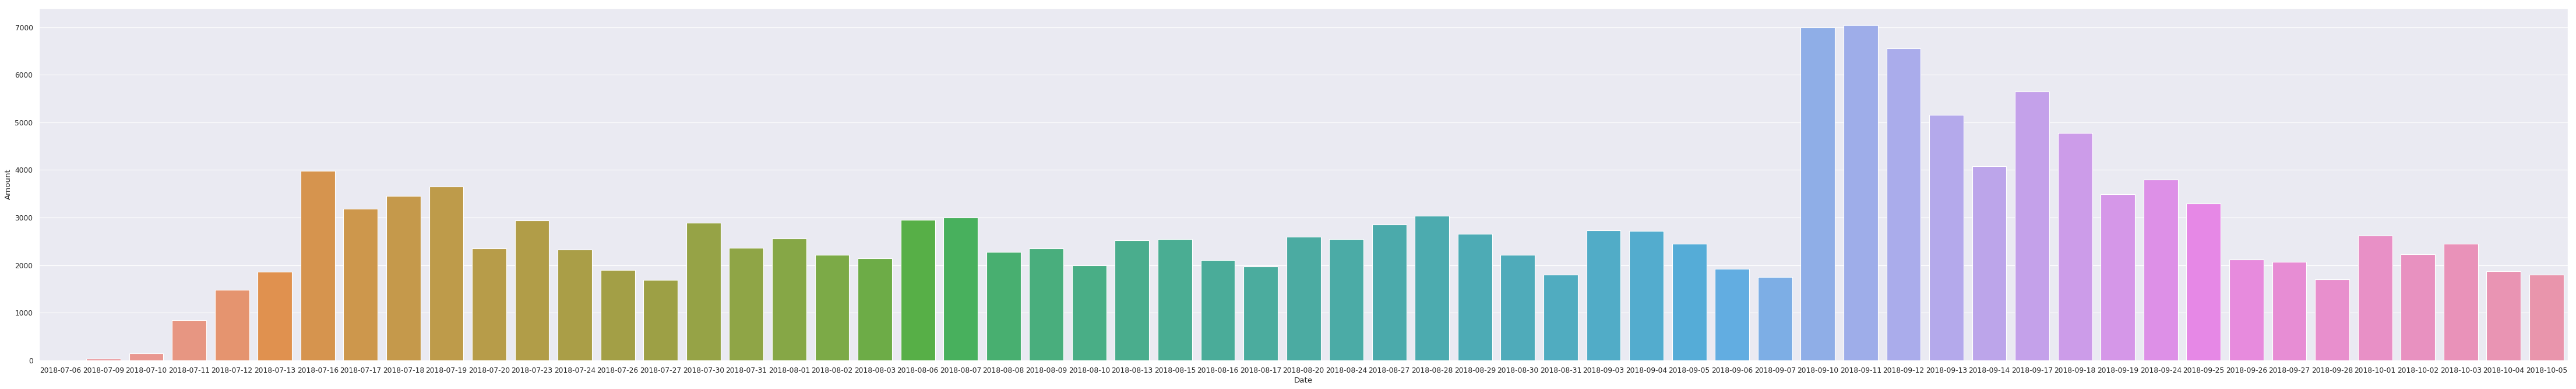

In [7]:
grouped_by_date = clean_data.groupby("Date")

daily_totals = grouped_by_date.count()
daily_totals_2 = daily_totals.reset_index()


fig = plt.figure(figsize=(70,10), dpi=80)
sns.set()
total_x = daily_totals_2.iloc[0:,0].dt.strftime('%Y-%m-%d')
total_y = daily_totals_2.iloc[0:,3]
ax = sns.barplot(x=total_x, y=total_y)

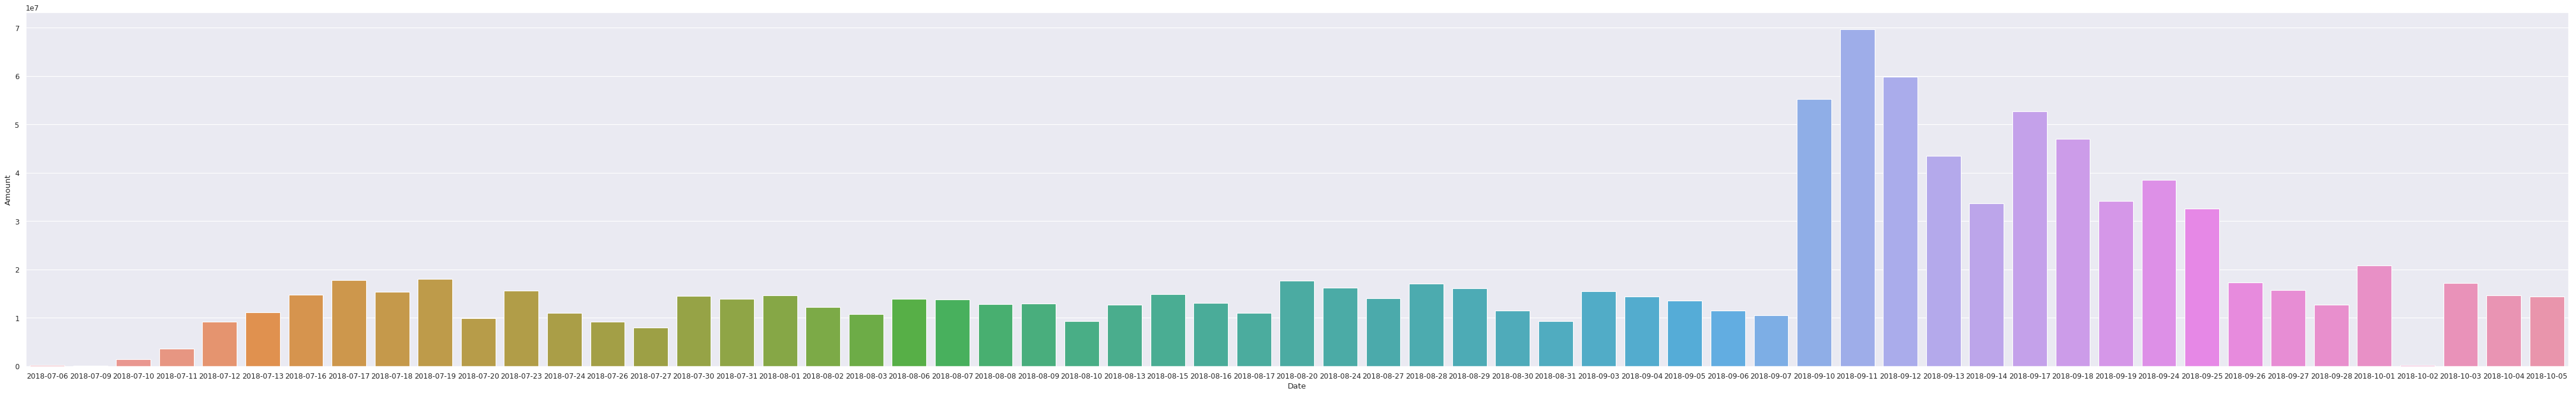

In [12]:
daily_counts = grouped_by_date.agg(np.sum)
daily_counts_2 = daily_counts.reset_index()

count_x = daily_counts_2.iloc[0:,0].dt.strftime('%Y-%m-%d')
count_y = daily_counts_2.iloc[0:,1]

fig = plt.figure(figsize=(70,10), dpi=80)

sns.set()
sns.barplot(x= count_x, y= count_y); ## note you can put semicolon here to avoid printing of function text output
                                     ## Remove it and rerun to see what I am talking about

### Subpart 1-c: Finding Weekly Patterns
Here we'll try to look if there is any meaningful pattern to be found by adding a Day column into the dataframe, and then visualizing to see if the day of the week matters.

In [13]:
day_number_of_week = daily_totals_2.iloc[0:,0].apply(pd.Timestamp.weekday)

def to_name(x):

    if x == 0:
        return "Monday"
    elif x == 1:
        return "Tuesday"
    elif x == 2:
        return "Wednesday"
    elif x == 3:
        return "Thursday"
    elif x == 4:
        return "Friday"
    elif x == 5:
        return "Saturday"
    elif x == 6:
        return "Sunday"


day_names_week = day_number_of_week.apply(to_name)

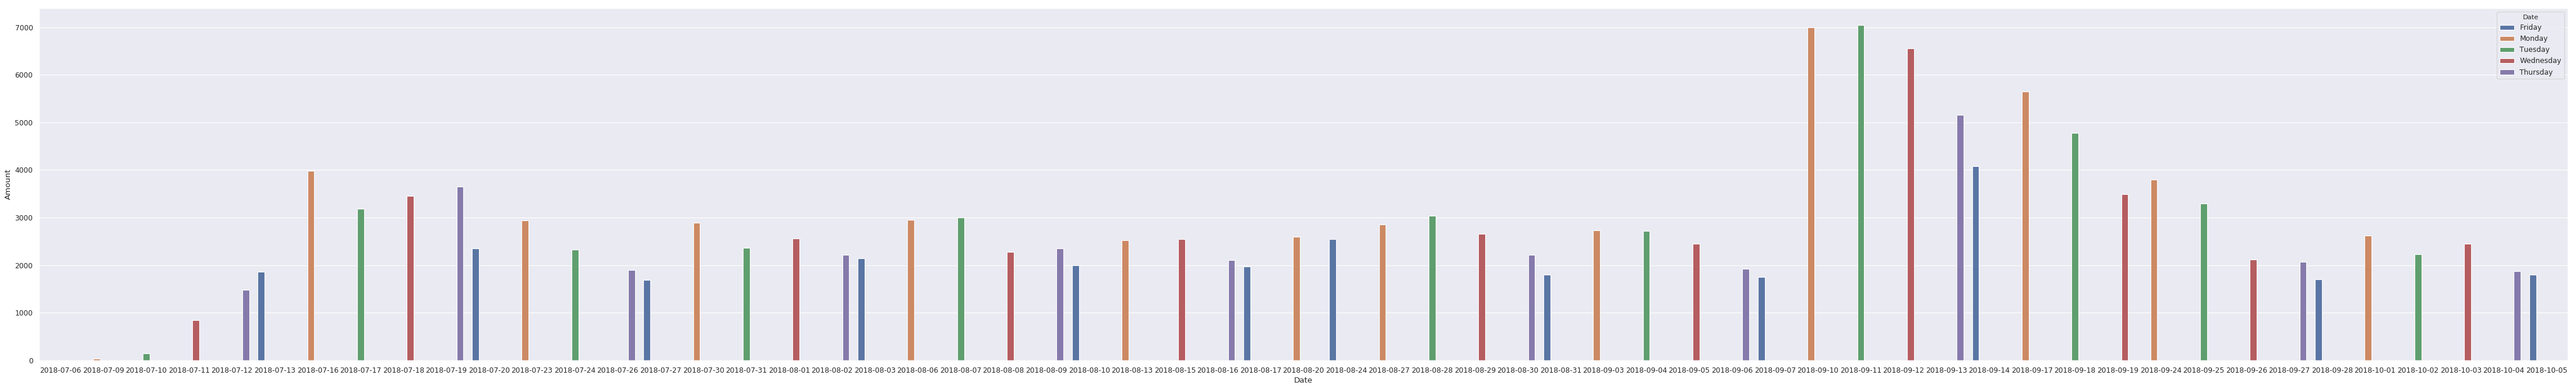

In [16]:
# Plotting a graph using either "hue" to 
# emphasise the Day along with the Date and Daily_Totals
# If you want to know more about hue, got to the documentation to see how it works!!!

fig = plt.figure(figsize=(70,10), dpi=80)
sns.set()
ax = sns.barplot(x=total_x, y=total_y, hue=day_names_week[0:]) 

## Double click on the graph to zoom in

# Feature Extraction and Regression

Now we'll be looking at the dataset in a completely different light. We'll move beyond simply analysing the data and will instead move towards trying to make some inferences regarding the data - predictions on when the dam's target value of (the minimum estimate) 1.5 Trillion rupees will be reached.

We'll be running a regression analysis on this data since the target variable, the funds collected, is a continuous variable. Before we are able to run any sort of regression we need to decide what features we should be using for our regression. Moreover, since we are running a regression it is important to also figure out what exactly our target variable should be. Should it be the **cumulative sum** of the amount collected **till** each day, or should it simply be the amount collected **on** each day?

In [20]:
# Code to calculate the target variable i.e. Cumulative Sum

clean_data["Amount"] = clean_data["Amount"].cumsum()
grouped_data = clean_data.groupby('Date')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Feature Extraction

We currently have 3 columns, other than the target variable (Amount), Bank, Name and Date). Which do you think should be used as the independent variable in running the regression?

You guessed it right :D !!! **Date** should be used as independent variable as we can control which interval to select and can see various relations like if weekends have some high donations or start of the months have high donations etc. 
Moreover, Bank Names can also be selected to see which bank has high donations
Names is not a good choice to select as independent variable because they are highly unique and difficult to convert to numeric values.

But heres the problem !!!! , take no worry!! I'm here xD . We could use the Date variable, but it can not be used directly since it is a 'Datetime' object. However, read up more on Linear Regression on the [sklearn Documentation page](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to know about what sort of independent variables must be sent to it.

There are many different ways we can extract the right features from just the datetime column. Some useful in-built functions include the sklearn library's [LabelEncoder](http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder), the [OneHotEncoder](http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) and the [OrdinalEncoder](http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder).
And we'll be using one of them


### <center>More Coming Soon!!! May be fork yourself :)